Installation des dépendances :

In [112]:
# Installation des dépendances
import sys
!{sys.executable} -m pip install "numpy<2.0"
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pyspark
#{sys.executable} -m pip install tabulate


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


---

In [113]:
#import chess
#import chess.svg

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import spark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, sum as _sum, count , Column, lit, DataFrame ,  row_number
from pyspark.sql.window import Window
from pyspark.sql.utils import AnalysisException

# Configuration des répertoires de sauvegarde et de chargement des données
save_results_DIR	= 'results/'
save_figures_DIR	= 'figures/'
data_DIR			= 'data/'
data_FILE			= 'Sept_20_analysis.csv'

# Création des répertoires de sauvegarde
from os import makedirs

makedirs(save_results_DIR, exist_ok=True)
makedirs(save_figures_DIR, exist_ok=True)

# Initialiser une session Spark
spark = SparkSession.builder.appName("Lichess Analysis").getOrCreate()

# Charger les données depuis le fichier CSV (remplacez par le chemin du fichier si besoin)
data_path = data_DIR + data_FILE
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Aperçu des données
#df.show(5)
print("\nDimensions du dataset :", (df.count(), len(df.columns)))



Dimensions du dataset : (3739909, 40)


# Question 1 :
Quel est le taux de bévues, d'erreurs et d'imprécisions par coup, par catégorie de niveau (*) et sur les différents types de parties ?  
Le classement d'une partie dans une catégorie, est fait en tenant compte  de l'ELO moyen des deux joueurs.

(*) Les catégories de niveau sont :
- [0-1199]    débutant
- [1200-1499] joueur occasionnel 
- [1500-1799] bon joueur de club 
- [1800-1999] très bon joueur de club 
- [2000-2399] niveau national et international (IM) 
- [2400-2800] GMI, champions du monde
- [2800+    ] Grands Maîtres

## Définition des catégories de niveau en fonction de l'ELO  :

In [114]:
# Définition des catégories elo :

ELO_CATEGORIES = ["beginner", 
         "occasional player", 
         "good club player", 
         "very good club player", 
         "national and international level (IM)", 
         "GMI, World Champions", 
         "Grand Master"]

def categorize_elo(columns):
    global ELO_CATEGORIES
    
    column: Column = None
    if isinstance(columns, tuple):
        # Calculer la moyenne des deux colonnes
        column = (col(columns[0]) + col(columns[1]))/2
    elif isinstance(columns, str):
        column = col(columns)
    elif not isinstance(columns, Column):
        raise ValueError("Invalid input")
    
    return  when(( column < 1200),                     ELO_CATEGORIES[0]) \
           .when(( column >= 1200) & (column < 1500),  ELO_CATEGORIES[1]) \
           .when(( column >= 1500) & (column < 1800),  ELO_CATEGORIES[2]) \
           .when(( column >= 1800) & (column < 2000),  ELO_CATEGORIES[3]) \
           .when(( column >= 2000) & (column < 2400),  ELO_CATEGORIES[4]) \
           .when(( column >= 2400) & (column <= 2800), ELO_CATEGORIES[5]) \
           .when(( column > 2800),                     ELO_CATEGORIES[6]) \
           .otherwise("Unknown")
           
#from pyspark.sql import functions as F

def order_dict_by_ELO(d: dict):
    """
        Trie selon les catgéories 
    """
    global ELO_CATEGORIES  
    
    for game_type, df in d.items():
        # Vérifier si la colonne 'Category' existe dans le DataFrame
        if "Category" in df.columns:
            # Ajouter une colonne temporaire '_order' basée sur l'ordre dans ELO_CATEGORIES
            order_expr = lit(len(ELO_CATEGORIES) + 1)  # Valeur par défaut pour les catégories inconnues
            for idx, cat in enumerate(ELO_CATEGORIES, start=1):
                order_expr = when(col("Category") == cat, idx).otherwise(order_expr)
            
            df = df.withColumn("_order", order_expr)  # Appliquer l'expression de tri
            
            # Trier le DataFrame par la colonne '_order' et supprimer cette colonne
            df = df.orderBy("_order").drop("_order")
            
            # Mettre à jour le DataFrame trié dans le dictionnaire
            d[game_type] = df
    
    return d


# Ajouter les colonnes pour les catégories des joueurs
df = df.withColumn("White_elo_category", categorize_elo("WhiteElo"))
df = df.withColumn("Black_elo_category", categorize_elo("BlackElo"))
df = df.withColumn("Average_elo_category", categorize_elo( ("WhiteElo","BlackElo") ))

## Calcul des taux par type de parties :
Dans un premier temps, on s'intéresse aux taux de bévues, d'erreurs et d'imprécisions par type de parties.  
On va afficher ces taux globalement en faisant fi des des disparités de niveau entre les joueurs.  
Toutefois, en classant le niveau de la partie en fonction de l'ELO moyen des deux joueurs, on pourra affiner les résultats.
On va donc pour chaque type de partie, afficher ces taux en fonction de la catégorie de niveau de la partie.
On s'attend donc globalement à avoir des taux plus importants pour les parties de niveau plus faible.
De même, on s'attend à avoir des taux plus importants pour les parties les plus courtes (bullet) et les taux les plus faibles pour les parties les plus longues (classique).

In [115]:

def calculate_rates_by_game_type(data, game_type_column)-> dict:
    rates : dict = {}
    game_types = data.select(game_type_column).distinct().rdd.flatMap(lambda x: x).collect()

    for game_type in game_types:
        # Filtrer les données pour le type de partie en cours
        filtered_data = data.filter(col(game_type_column) == game_type)
        
        # Calcul des métriques par catégorie d'ELO moyenne
        aggregated = filtered_data.groupBy("Average_elo_category").agg(
            ((_sum(col("Black_blunders")) + _sum(col("White_blunders"))) / _sum(col("Total_moves"))).alias("Blunder_rate"),
            ((_sum(col("Black_mistakes")) + _sum(col("White_mistakes"))) / _sum(col("Total_moves"))).alias("Mistake_rate"),
            ((_sum(col("Black_inaccuracies")) + _sum(col("White_inaccuracies"))) / _sum(col("Total_moves"))).alias("Inaccuracy_rate")
        )
        
        # Renommer les colonnes avec des noms explicites incluant le type de partie
        renamed = aggregated.select(
            col("Average_elo_category").alias("Category"),
            col("Blunder_rate").alias(f"{game_type}_Blunder_rate"),
            col("Mistake_rate").alias(f"{game_type}_Mistake_rate"),
            col("Inaccuracy_rate").alias(f"{game_type}_Inaccuracy_rate")
        )
        
        # Ajouter les résultats dans le dictionnaire
        rates[game_type] = renamed

    order_dict_by_ELO(rates)
    
    return rates


rates_by_game_type = calculate_rates_by_game_type(df, "Game_type")

for game_type, rates in rates_by_game_type.items():
    print(f"\nTaux pour les parties de type {game_type} :")
    # Récupérer les données
    data = rates.collect()
    header = f"{'Category':50} | {'Blunder Rate':<15} | {'Mistake Rate':<15} | {'Inaccuracy Rate':<15}"
    print(header)
    print("-" * len(header))
    for row in data:
        print(f"{row['Category'] : <50}{row[f'{game_type}_Blunder_rate'] : ^15.2%}{row[f'{game_type}_Mistake_rate'] : ^15.2%}{row[f'{game_type}_Inaccuracy_rate'] : >15.2%}")


Taux pour les parties de type Bullet :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                               9.58%         10.50%               9.39%
occasional player                                      8.17%         10.37%               9.44%
good club player                                       6.87%         10.12%               9.48%
very good club player                                  5.88%          9.72%               9.36%
national and international level (IM)                  5.13%          8.97%               8.97%
GMI, World Champions                                   4.30%          7.72%               7.95%
Grand Master                                           4.08%          7.30%               7.59%

Taux pour les parties de type Blitz :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                               9.42%         10.62%               9.01%
occasional player                                      7.46%         10.26%               9.03%
good club player                                       5.92%          9.74%               9.07%
very good club player                                  4.89%          9.05%               8.87%
national and international level (IM)                  4.07%          8.06%               8.30%
GMI, World Champions                                   3.17%          6.57%               7.25%
Grand Master                                           2.54%          5.31%               6.39%

Taux pour les parties de type Classical :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                              10.18%         10.48%               8.90%
occasional player                                      7.48%         10.08%               8.70%
good club player                                       5.32%          9.27%               8.59%
very good club player                                  3.91%          8.23%               8.22%
national and international level (IM)                  2.91%          6.83%               7.57%
GMI, World Champions                                   1.58%          3.87%               5.63%

Taux pour les parties de type Rapid :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                              10.03%         10.62%               8.84%
occasional player                                      7.50%         10.23%               8.69%
good club player                                       5.74%          9.65%               8.70%
very good club player                                  4.56%          8.87%               8.60%
national and international level (IM)                  3.62%          7.67%               8.00%
GMI, World Champions                                   2.28%          5.50%               6.62%

Taux pour les parties de type Correspondence :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                              12.03%          8.12%               7.19%
occasional player                                      7.16%          9.68%               8.16%
good club player                                       5.41%          9.16%               8.37%
very good club player                                  3.50%          8.20%               8.35%
national and international level (IM)                  1.90%          5.32%               6.96%
GMI, World Champions                                   0.29%          0.78%               2.25%


Nos attentes sont confirmées par les résultats obtenus.
Globalement, plus la partie est courte, plus les taux sont élevés.
De même, plus le niveau de la partie est faible, plus les taux sont élevés et inversement.
De plus si l'écart du taux d'erreurs/ bévues / imprécisions entre les plus faibles et les plus forts est relativement important pour les parties les plus longues, l'écart se réduit pour les parties les plus courtes.

### Calcul des taux dans une même catégorie ELO et par type de partie

In [116]:
# Filtrer les parties où les deux joueurs sont dans la même catégorie, par type de partie
def calculate_rates_for_same_category(data, game_type_column) -> dict :
    rates :dict = {}
    game_types = data.select(game_type_column).distinct().rdd.flatMap(lambda x: x).collect()
    for game_type in game_types:    
        filtered_data = data.filter((col(game_type_column) == game_type) & (col("White_elo_category") == col("Black_elo_category")))
        rates_by_category = filtered_data.groupBy("White_elo_category").agg(
            ( (_sum(col("Black_blunders")) + _sum(col("White_blunders"))) / _sum(col("Total_moves")) ).alias("Blunder_rate"),
            ( (_sum(col("Black_mistakes")) + _sum(col("White_mistakes"))) / _sum(col("Total_moves")) ).alias("Mistake_rate"),
            ( (_sum(col("Black_inaccuracies")) + _sum(col("White_inaccuracies"))) / _sum(col("Total_moves")) ).alias("Inaccuracy_rate")
        )
        #renamed = rates_by_category
        renamed = rates_by_category.select(
            col("White_elo_category").alias("Category"),
            col("Blunder_rate").alias("Blunder_rate"),
            col("Mistake_rate").alias("Mistake_rate"),
            col("Inaccuracy_rate").alias("Inaccuracy_rate")
        ).orderBy("Category")
        
        rates[game_type] = renamed
        
    order_dict_by_ELO(rates)
    
    return rates

rates_same_category_by_game_type = calculate_rates_for_same_category(df, "Game_type")

for game_type, rates in rates_same_category_by_game_type.items():
    print(f"\nTaux pour les parties de type {game_type} avec joueurs dans la même catégorie :")
    data = rates.collect()
    header = f"{'Category':50} | {'Blunder Rate':<15} | {'Mistake Rate':<15} | {'Inaccuracy Rate':<15}"
    print(header)
    print("-" * len(header))
    for row in data:
        print(f"{row['Category'] : <50}{row['Blunder_rate'] : ^15.2%}{row['Mistake_rate'] : ^15.2%}{row['Inaccuracy_rate'] : >15.2%}")
    


Taux pour les parties de type Bullet avec joueurs dans la même catégorie :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                               9.59%         10.52%               9.38%
occasional player                                      7.93%         10.45%               9.46%
good club player                                       6.73%         10.20%               9.52%
very good club player                                  5.84%          9.81%               9.42%
national and international level (IM)                  5.10%          9.02%               9.01%
GMI, World Champions                                   4.26%          7.68%               7.93%
Grand Master                                           4.10%          7.32%               7.55%

Taux pour les parties de type Blitz avec joueurs dans la même catégorie :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                               9.47%         10.68%               8.99%
occasional player                                      7.36%         10.36%               9.02%
good club player                                       5.96%          9.85%               9.10%
very good club player                                  4.98%          9.19%               8.93%
national and international level (IM)                  4.11%          8.10%               8.32%
GMI, World Champions                                   3.15%          6.49%               7.19%
Grand Master                                           3.51%          5.50%               6.05%

Taux pour les parties de type Classical avec joueurs dans la même catégorie :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                              10.53%         10.64%               8.94%
occasional player                                      7.79%         10.32%               8.70%
good club player                                       5.51%          9.47%               8.66%
very good club player                                  4.04%          8.44%               8.31%
national and international level (IM)                  2.86%          6.78%               7.54%
GMI, World Champions                                   1.41%          3.87%               5.58%

Taux pour les parties de type Rapid avec joueurs dans la même catégorie :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                              10.20%         10.70%               8.85%
occasional player                                      7.56%         10.34%               8.69%
good club player                                       5.83%          9.76%               8.73%
very good club player                                  4.68%          9.03%               8.68%
national and international level (IM)                  3.62%          7.65%               7.99%
GMI, World Champions                                   2.09%          5.52%               6.30%

Taux pour les parties de type Correspondence avec joueurs dans la même catégorie :


Category                                           | Blunder Rate    | Mistake Rate    | Inaccuracy Rate
--------------------------------------------------------------------------------------------------------
beginner                                               8.62%          3.45%              12.07%
occasional player                                      7.43%          9.98%               8.30%
good club player                                       5.63%          9.34%               8.37%
very good club player                                  3.47%          8.19%               8.64%
national and international level (IM)                  1.83%          4.96%               6.62%
GMI, World Champions                                   0.13%          0.63%               2.14%


### Visualisation des données

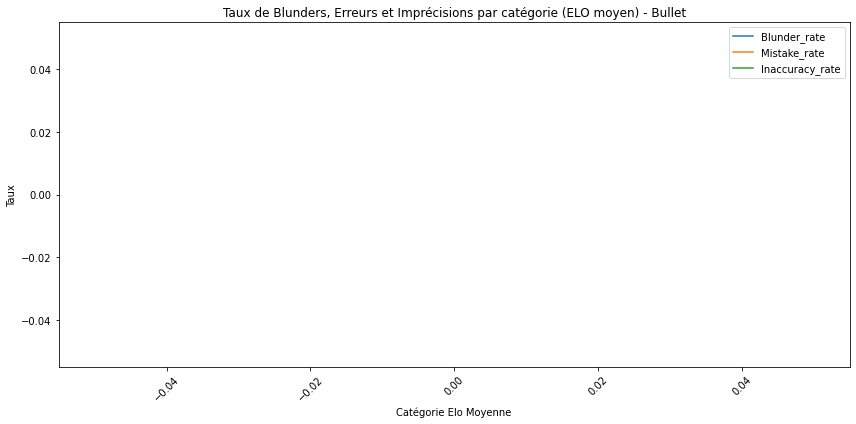

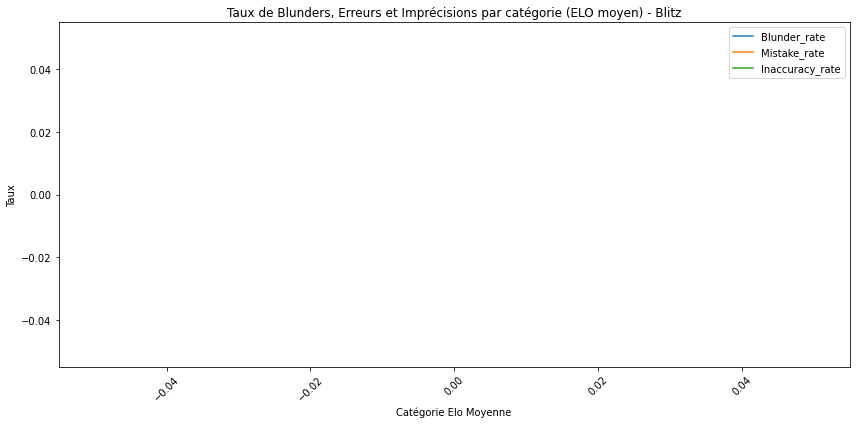

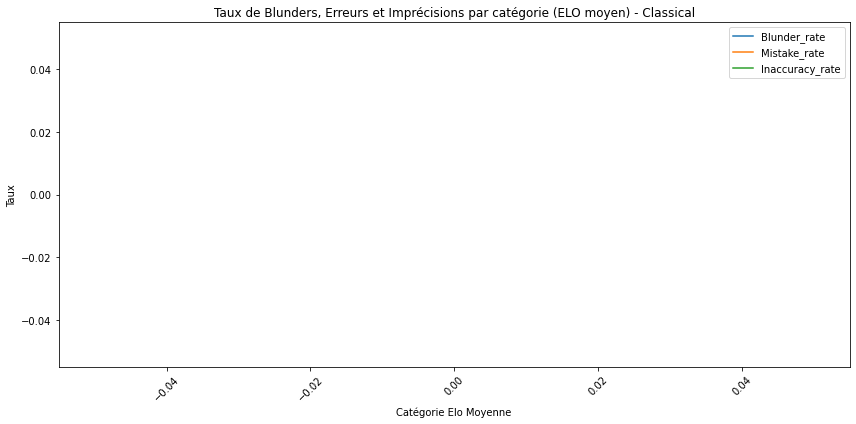

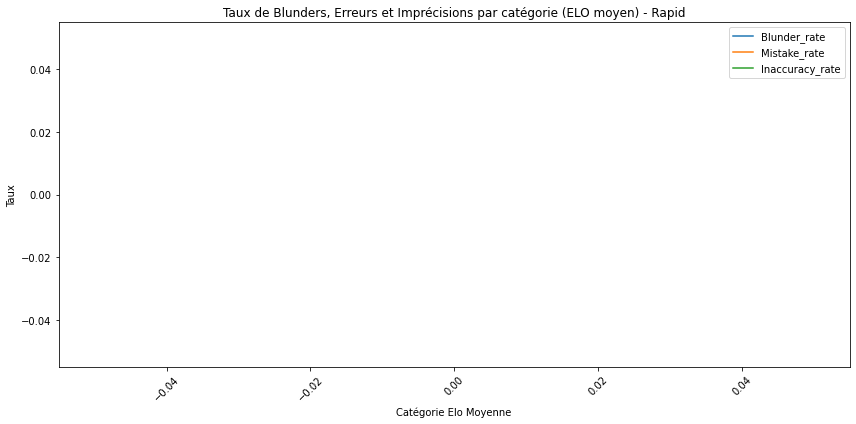

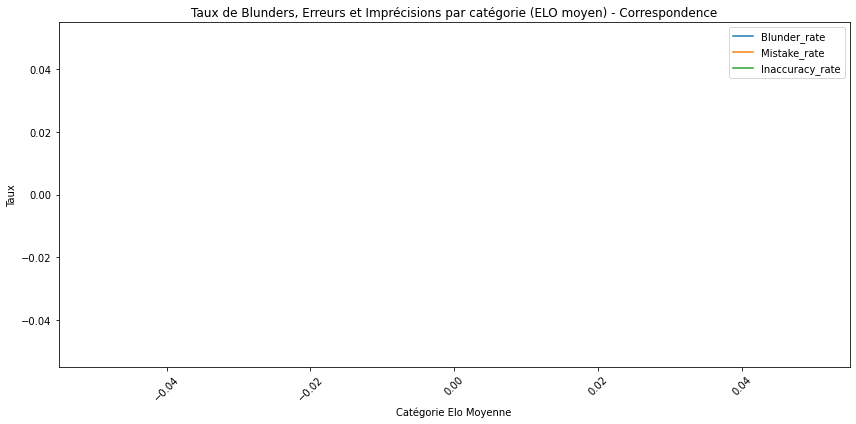

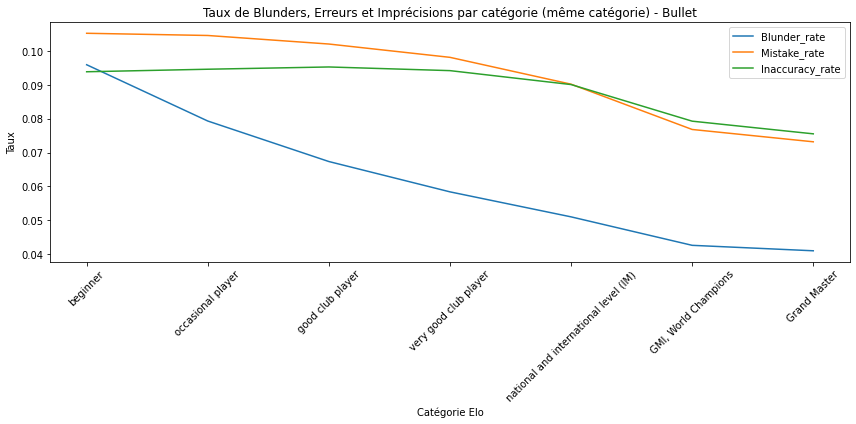

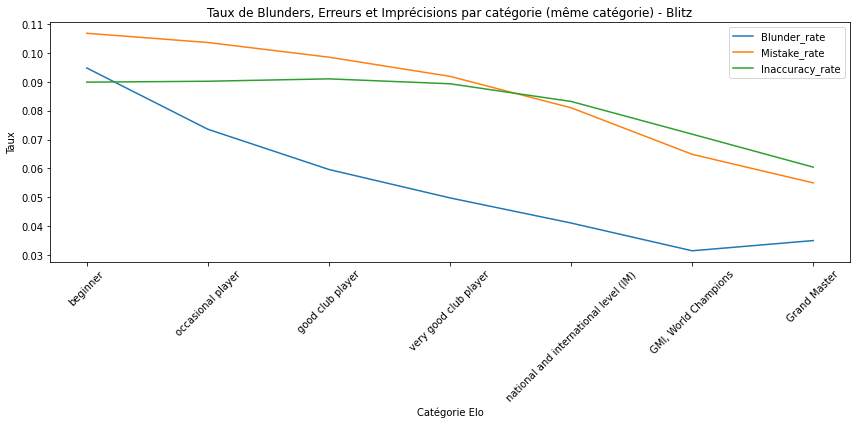

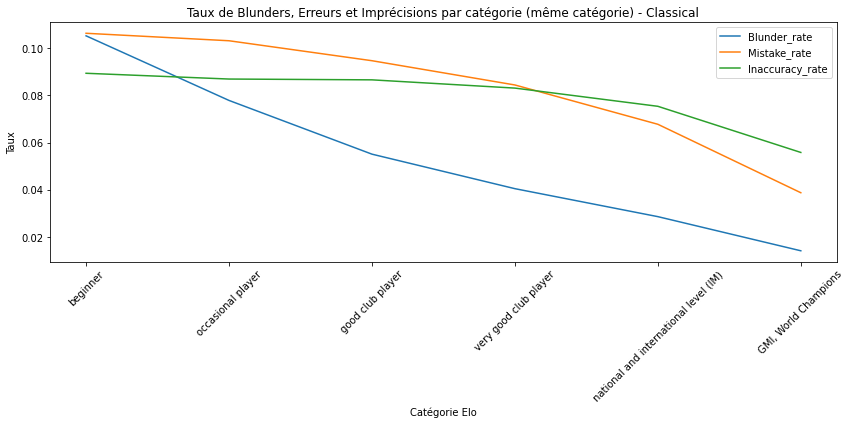

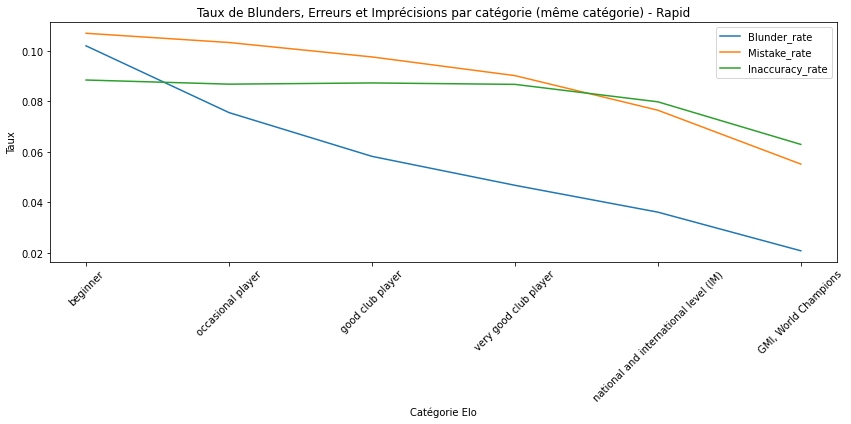

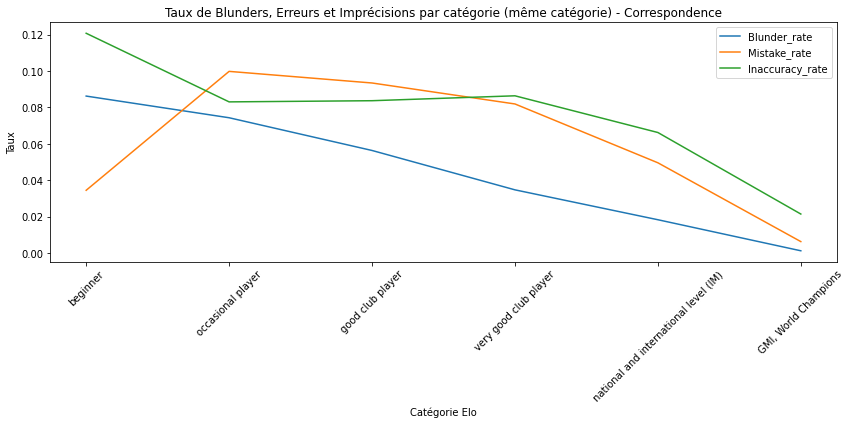

In [117]:
for game_type, rates in rates_by_game_type.items():
    rates_pd = rates.toPandas()
    rates_pd_melted = pd.melt(rates_pd, id_vars=['Category'], var_name='Metric', value_name='Rate')

    plt.figure(figsize=(12, 6))
    for metric in ['Blunder_rate', 'Mistake_rate', 'Inaccuracy_rate']:
        subset = rates_pd_melted[rates_pd_melted['Metric'] == metric]
        plt.plot(subset['Category'], subset['Rate'], label=metric)

    plt.title(f'Taux de Blunders, Erreurs et Imprécisions par catégorie (ELO moyen) - {game_type}')
    plt.xlabel('Catégorie Elo Moyenne')
    plt.ylabel('Taux')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_figures_DIR + f'rates_by_category_{game_type}.png')
    plt.show()
    plt.close()

for game_type, rates in rates_same_category_by_game_type.items():
    rates_pd = rates.toPandas()
    rates_pd_melted = pd.melt(rates_pd, id_vars=['Category'], var_name='Metric', value_name='Rate')

    plt.figure(figsize=(12, 6))
    for metric in ['Blunder_rate', 'Mistake_rate', 'Inaccuracy_rate']:
        subset = rates_pd_melted[rates_pd_melted['Metric'] == metric]
        plt.plot(subset['Category'], subset['Rate'], label=metric)

    plt.title(f'Taux de Blunders, Erreurs et Imprécisions par catégorie (même catégorie) - {game_type}')
    plt.xlabel('Catégorie Elo')
    plt.ylabel('Taux')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_figures_DIR + f'rates_same_category_{game_type}.png')
    plt.show()
    plt.close()

### Sauvegarde des résultats

In [118]:
for game_type, rates in rates_by_game_type.items():
    path = f"{save_results_DIR}rates_by_average_elo_{game_type}.csv"
    try:
        rates.write.csv(path, header=True)
        print(f"\nLes résultats pour les parties de type {game_type} ont été sauvegardés dans {path}.")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des résultats pour le type de partie {game_type} : {e}")

for game_type, rates in rates_same_category_by_game_type.items():
    path = f"{save_results_DIR}rates_same_category_{game_type}.csv"
    try:
        rates.write.csv(path, header=True)
        print(f"\nLes résultats pour les parties de type {game_type} avec joueurs dans la même catégorie ont été sauvegardés dans {path}.")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des résultats pour le type de partie {game_type} : {e}")


Erreur lors de la sauvegarde des résultats pour le type de partie Bullet : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_by_average_elo_Bullet.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Blitz : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_by_average_elo_Blitz.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Classical : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_by_average_elo_Classical.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Rapid : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_by_average_elo_Rapid.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Correspondence : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_by_average_elo_Correspondence.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Bullet : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_same_category_Bullet.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Blitz : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_same_category_Blitz.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Classical : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_same_category_Classical.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Rapid : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_same_category_Rapid.csv already exists. Set mode as "overwrite" to overwrite the existing path.


Erreur lors de la sauvegarde des résultats pour le type de partie Correspondence : [PATH_ALREADY_EXISTS] Path file:/home/julien/Cours/Cours3A/Traitement_donnees/Projet/Projet-Processing/results/rates_same_category_Correspondence.csv already exists. Set mode as "overwrite" to overwrite the existing path.


---

# Etude sur les facteurs de victoires

En dehors des erreurs, bévues et imprécisions des joueurs, d'autres facteurs peuvent influencer le résultat d'une partie.
On se demande donc à présent quelles caractéristiques influent sur le résultat d'une partie et dans quelle mesure.
Des facteurs de victoires apparents semblent être  la couleur et le niveau des joueurs.
En effet, les blancs jouant en premier pourraient librement développer leur jeu et ainsi avoir un avantage sur les noirs.
De plus, les joueurs de niveau plus élevé pourraient avoir un avantage sur les joueurs de niveau inférieur, étant à priori plus expérimentés et/ou plus compétents.
On pourra donc se demander :  
- Les blancs ont-ils un avantage sur les noirs ?  
- Etant les premiers à jouer, ont-ils plus de chance de gagner ?  
- Si oui, cet avantage est-il plus marqué selon les parties plus ou moins longues ?  
- Cet avantage est-il plus marqué selon le niveau des joueurs ?  
- Si le premier coup offre un avantage, est-ce que l'expérience supérieure de l'adverse peut lui permettre de palier à cet avantage ?  

In [119]:
def result_proportions(df):
    """Propensions globales des résultats."""
    total_games = df.count()  # Nombre total de parties
    return df.groupBy("Result").agg(
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")

def global_result_by_category_and_type(df):
    """Proportions des résultats par niveau moyen d'elo et type de partie, avec calcul correct des proportions."""
    
    # Calcul du nombre total de parties par catégorie d'elo moyen et type de partie
    window = Window.partitionBy("Average_elo_category", "Game_type")
    
    # Calcul du nombre total de parties, renommé pour éviter les conflits
    total_games = df.groupBy("Average_elo_category", "Game_type").count().withColumnRenamed("count", "Total")
    
    # Calcul des résultats et du nombre de parties par catégorie d'elo et type de partie
    results = df.groupBy("Average_elo_category", "Game_type", "Result").agg(
        count("*").alias("Count")
    )
    
    # Fusionner les résultats avec les totaux pour chaque groupe (catégorie + type de partie)
    results_with_totals = results.join(total_games, on=["Average_elo_category", "Game_type"], how="inner")
    
    # Calcul des proportions
    results_with_proportions = results_with_totals.withColumn(
        "Proportion", col("Count") / col("Total")
    ).orderBy("Average_elo_category", "Game_type", "Result")
    
    # Créer un dictionnaire pour les résultats par type de partie
    results_dict = {}
    game_types = df.select("Game_type").distinct().rdd.flatMap(lambda x: x).collect()
    
    for game_type in game_types:
        filtered_data = results_with_proportions.filter(col("Game_type") == game_type)
        
        # Réorganiser les résultats par catégorie et type de partie
        renamed = filtered_data.select(
            col("Average_elo_category").alias("Category"),
            col("Result").alias("Result"),
            col("Count").alias(f"{game_type}_Count"),  # Renommage de Count pour éviter ambiguïté
            col("Proportion").alias(f"{game_type}_Proportion")  # Renommage de Proportion
        ).orderBy("Category", "Result")
        
        results_dict[game_type] = renamed
    
    return results_dict

# Exemple d'utilisation
global_result_by_category_type = global_result_by_category_and_type(df)

# Affichage des résultats
for game_type, results in global_result_by_category_type.items():
    print(f"Résultats pour les parties de type {game_type} :\n")
    header = f"{'Category': <50}{'Result': ^15}{f'{game_type}_Count': ^10}{f'{game_type}_Proportion': >15}"
    print(header)
    print("-" * len(header))
    
    # Conversion des données en liste pour un affichage plus simple
    data = results.collect()
    for row in data:
        print(f"{row['Category'] : <50}{row['Result'] : ^15}{row[f'{game_type}_Count'] : ^10}{row[f'{game_type}_Proportion'] : >15.2%}")


def white_result_when_elo_higher(df):
    """Propensions des blancs lorsque leur ELO est supérieur à celui des noirs."""
    filtered = df.filter(col("WhiteElo") > col("BlackElo"))
    total_games = filtered.count()
    return filtered.groupBy("Result").agg(
        count("*").alias("Count"),
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")

def white_result_higher_elo_diff_category(df):
    """Résultats des blancs lorsque leur ELO est supérieur à celui des noirs et que les catégories diffèrent."""
    filtered = df.filter(
        (col("WhiteElo") > col("BlackElo")) & 
        (col("White_elo_category") != col("Black_elo_category"))
    )
    total_games = filtered.count()
    return filtered.groupBy("Result").agg(
        count("*").alias("Count"),
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")

def black_result_when_elo_higher(df):
    """Résultats des noirs lorsque leur ELO est supérieur à celui des blancs."""
    filtered = df.filter(col("BlackElo") > col("WhiteElo"))
    total_games = filtered.count()
    return filtered.groupBy("Result").agg(
        count("*").alias("Count"),
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")
    
def black_result_when_elo_higher_diff_category(df):
    """Résultats des noirs lorsque leur ELO est supérieur à celui des blancs et que les catégories diffèrent."""
    filtered = df.filter(
        (col("BlackElo") > col("WhiteElo")) & 
        (col("White_elo_category") != col("Black_elo_category"))
    )
    total_games = filtered.count()
    return filtered.groupBy("Result").agg(
        count("*").alias("Count"),
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")

def result_when_elo_higher(df):
    """Propensions globales (sans distinction de couleur) pour les joueurs avec un ELO supérieur."""
    filtered = df.filter(col("WhiteElo") != col("BlackElo"))
    total_games = filtered.count()
    return filtered.groupBy("Result").agg(
        count("*").alias("Count"),
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")

def result_higher_elo_diff_category(df):
    """Propensions globales pour les joueurs avec un ELO supérieur et des catégories différentes."""
    filtered = df.filter(
        (col("WhiteElo") != col("BlackElo")) & 
        (col("White_elo_category") != col("Black_elo_category"))
    )
    total_games = filtered.count()
    return filtered.groupBy("Result").agg(
        count("*").alias("Count"),
        (count("*") / total_games).alias("Proportion")
    ).orderBy("Result")
    
    
# Afficher les propensions des résultats
def print_result_proportions(res):
    """Afficher les propensions des résultats."""
    match_result = {"1-0": "Victoire Blancs", "0-1": "Victoire Noirs", "1/2-1/2": "Nul", "*": "Résultat inconnu"}
    results = res.collect()
    for row in results:
        if row['Result'] == "*":
            continue
        print(f"{match_result[row['Result']]:<10} : {row['Proportion']:.2%}")


Résultats pour les parties de type Bullet :

Category                                              Result     Bullet_CountBullet_Proportion
----------------------------------------------------------------------------------------------


GMI, World Champions                                     *           1               0.01%
GMI, World Champions                                    0-1         4440            44.34%
GMI, World Champions                                    1-0         4932            49.26%
GMI, World Champions                                  1/2-1/2       640              6.39%
Grand Master                                            0-1         502             42.43%
Grand Master                                            1-0         592             50.04%
Grand Master                                          1/2-1/2        89              7.52%
beginner                                                0-1        62567            49.38%
beginner                                                1-0        63138            49.83%
beginner                                              1/2-1/2       999              0.79%
good club player                                         *           2               0.00%

GMI, World Champions                                     *           3               0.01%
GMI, World Champions                                    0-1         8772            42.29%
GMI, World Champions                                    1-0         9835            47.42%
GMI, World Champions                                  1/2-1/2       2132            10.28%
Grand Master                                            0-1          52             40.00%
Grand Master                                            1-0          62             47.69%
Grand Master                                          1/2-1/2        16             12.31%
beginner                                                 *           1               0.00%
beginner                                                0-1        111259           47.91%
beginner                                                1-0        116463           50.16%
beginner                                              1/2-1/2       4482             1.93%

GMI, World Champions                                    0-1          34             41.98%
GMI, World Champions                                    1-0          29             35.80%
GMI, World Champions                                  1/2-1/2        18             22.22%
beginner                                                0-1         2602            47.57%
beginner                                                1-0         2726            49.84%
beginner                                              1/2-1/2       142              2.60%
good club player                                         *           1               0.00%
good club player                                        0-1        30555            47.23%
good club player                                        1-0        31961            49.40%
good club player                                      1/2-1/2       2183             3.37%
national and international level (IM)                    *           4               0.03%

GMI, World Champions                                    0-1         408             40.80%
GMI, World Champions                                    1-0         455             45.50%
GMI, World Champions                                  1/2-1/2       137             13.70%
beginner                                                 *           1               0.00%
beginner                                                0-1        43348            47.91%
beginner                                                1-0        45248            50.01%
beginner                                              1/2-1/2       1889             2.09%
good club player                                         *           5               0.00%
good club player                                        0-1        164112           46.96%
good club player                                        1-0        174216           49.85%
good club player                                      1/2-1/2      11132             3.19%

GMI, World Champions                                    0-1          5              26.32%
GMI, World Champions                                    1-0          5              26.32%
GMI, World Champions                                  1/2-1/2        9              47.37%
beginner                                                0-1          6              75.00%
beginner                                                1-0          2              25.00%
good club player                                        0-1         2397            46.13%
good club player                                        1-0         2562            49.31%
good club player                                      1/2-1/2       237              4.56%
national and international level (IM)                   0-1         377             39.89%
national and international level (IM)                   1-0         426             45.08%
national and international level (IM)                 1/2-1/2       142             15.03%

In [120]:
# Propensions globales des blancs
print("\nPropensions des résultats globaux :")
global_result = result_proportions(df)
print_result_proportions(global_result)

# Propensions par niveau et type de partie
print("\nPropensions des résultats par niveau et par type de partie :")

global_result_by_category_type = global_result_by_category_and_type(df)

for game_type, results in global_result_by_category_type.items():
    print(f"\nRésultats pour les parties de type {game_type} :")
    match_result = {"1-0": "Victoire Blancs", "0-1": "Victoire Noirs", "1/2-1/2": "Nul", "*": "Résultat inconnu"}
    data = results.collect()
    header = f"{'Category':<50} | {'Result':30} | {'Count':10} | {'Proportion':>15}"
    print(header)
    print("-" * len(header))
    for row in data:
        if row['Result'] == "*":
            continue
    
        print(f"{row['Category'] : <50}{match_result[row['Result']] : ^30}{row[f'{game_type}_Count'] : ^10}{row[f'{game_type}_Proportion'] : >15.2%}")


# Propensions des résultats des blancs avec ELO supérieur
white_elo_higher = white_result_when_elo_higher(df)
#white_elo_higher.show()
print("\nPropensions des résultats des blancs avec ELO supérieur :")
print_result_proportions(white_elo_higher)

# Propensions des résultats des blancs avec ELO supérieur + catégories différentes
white_elo_diff_category = white_result_higher_elo_diff_category(df)
#white_elo_diff_category.show()
print("\nPropensions des résultats des blancs avec ELO supérieur et catégories différentes :")
print_result_proportions(white_elo_diff_category)

# Propensions des résultats des noirs avec ELO supérieur
black_elo_higher = black_result_when_elo_higher(df)
#black_elo_higher.show()
print("\nPropensions des résultats des noirs avec ELO supérieur :")
print_result_proportions(black_elo_higher)

# Propensions des résultats des noirs avec ELO supérieur + catégories différentes
black_elo_higher_diff_category = black_result_when_elo_higher_diff_category(df)
#black_elo_higher_diff_category.show()
print("\nPropensions des résultats des noirs avec ELO supérieur et catégories différentes :")
print_result_proportions(black_elo_higher_diff_category)


Propensions des résultats globaux :


Victoire Noirs : 47.23%
Victoire Blancs : 49.84%
Nul        : 2.93%

Propensions des résultats par niveau et par type de partie :



Résultats pour les parties de type Bullet :


Category                                           | Result                         | Count      |      Proportion
------------------------------------------------------------------------------------------------------------------
GMI, World Champions                                      Victoire Noirs           4440            44.34%
GMI, World Champions                                     Victoire Blancs           4932            49.26%
GMI, World Champions                                           Nul                 640              6.39%
Grand Master                                              Victoire Noirs           502             42.43%
Grand Master                                             Victoire Blancs           592             50.04%
Grand Master                                                   Nul                  89              7.52%
beginner                                                  Victoire Noirs          62567            49.38%
beginner                    

Category                                           | Result                         | Count      |      Proportion
------------------------------------------------------------------------------------------------------------------
GMI, World Champions                                      Victoire Noirs           8772            42.29%
GMI, World Champions                                     Victoire Blancs           9835            47.42%
GMI, World Champions                                           Nul                 2132            10.28%
Grand Master                                              Victoire Noirs            52             40.00%
Grand Master                                             Victoire Blancs            62             47.69%
Grand Master                                                   Nul                  16             12.31%
beginner                                                  Victoire Noirs          111259           47.91%
beginner                    

Category                                           | Result                         | Count      |      Proportion
------------------------------------------------------------------------------------------------------------------
GMI, World Champions                                      Victoire Noirs            34             41.98%
GMI, World Champions                                     Victoire Blancs            29             35.80%
GMI, World Champions                                           Nul                  18             22.22%
beginner                                                  Victoire Noirs           2602            47.57%
beginner                                                 Victoire Blancs           2726            49.84%
beginner                                                       Nul                 142              2.60%
good club player                                          Victoire Noirs          30555            47.23%
good club player            

Category                                           | Result                         | Count      |      Proportion
------------------------------------------------------------------------------------------------------------------
GMI, World Champions                                      Victoire Noirs           408             40.80%
GMI, World Champions                                     Victoire Blancs           455             45.50%
GMI, World Champions                                           Nul                 137             13.70%
beginner                                                  Victoire Noirs          43348            47.91%
beginner                                                 Victoire Blancs          45248            50.01%
beginner                                                       Nul                 1889             2.09%
good club player                                          Victoire Noirs          164112           46.96%
good club player            

Category                                           | Result                         | Count      |      Proportion
------------------------------------------------------------------------------------------------------------------
GMI, World Champions                                      Victoire Noirs            5              26.32%
GMI, World Champions                                     Victoire Blancs            5              26.32%
GMI, World Champions                                           Nul                  9              47.37%
beginner                                                  Victoire Noirs            6              75.00%
beginner                                                 Victoire Blancs            2              25.00%
good club player                                          Victoire Noirs           2397            46.13%
good club player                                         Victoire Blancs           2562            49.31%
good club player            


Propensions des résultats des blancs avec ELO supérieur :


Victoire Noirs : 42.07%
Victoire Blancs : 55.02%
Nul        : 2.91%



Propensions des résultats des blancs avec ELO supérieur et catégories différentes :


Victoire Noirs : 34.29%
Victoire Blancs : 62.91%
Nul        : 2.80%



Propensions des résultats des noirs avec ELO supérieur :


Victoire Noirs : 52.35%
Victoire Blancs : 44.68%
Nul        : 2.97%



Propensions des résultats des noirs avec ELO supérieur et catégories différentes :


Victoire Noirs : 60.70%
Victoire Blancs : 36.34%
Nul        : 2.96%


On observe ici plusieurs choses :
- Les blancs semblent avoir un léger avantage globalement sur les noirs, leur taux de victoire est légèrement supérieur.
- Plus les parties sont courtes, plus cet avantage est marqué. Et ce, quelque soit le niveau des joueurs.
- En revanche, cet avantage est reduit pour les parties plus longues, et encore plus pour les parties de niveau plus élevé.
- Un joueur avec un elo plus élevé a un petit avantage sur un joueur avec un elo plus faible, quelque soit la couleur des pièces, avec toutefois, un léger bonus pour les blancs.
- Cet avantage est encore plus visible quand les catégories des joueurs sont différentes.

Notons tout de même que ces avantages sont relativement faibles.  
Hormis pour les parties où les joueurs ont des catégories de niveau différentes, les taux de victoire sont relativement proches.

---
# Question 2 :  
On s'intéresse maintenant aux stratégies permettant la victoire.  
Il s'agira donc ici de chercher à détecter les ouvertures les plus efficaces pour les blancs et les noirs.  
On déterminera ainsi les ouvertures les plus efficaces en fonction du niveau des joueurs et du type de parties. 
Pour mesure l'efficacité d'une ouverture, on se basera sur le taux de victoire des joueurs ayant joué cette ouverture rapporté au taux de victoire global des joueurs d'une même catégorie de niveau et ayant joué une partie du même type.

In [121]:
def top_openings_by_color_and_game_type(df, color="white",top = 5):
    """
    Top 3 ouvertures les plus efficaces pour chaque couleur (blancs ou noirs), 
    par type de partie et catégorie ELO moyenne.
    
    :param df: DataFrame Spark
    :param color: "white" ou "black" pour indiquer la couleur
    :return: Dictionnaire contenant les résultats par type de partie
    """
    # Vérifier la validité du paramètre color
    if color not in ["white", "black"]:
        raise ValueError("Le paramètre 'color' doit être 'white' ou 'black'.")
    
    # Définir les filtres en fonction de la couleur
    if color == "white":
        win_filter = col("Result") == "1-0"
    else:
        win_filter = col("Result") == "0-1"
    
    # Créer un dictionnaire pour stocker les résultats par type de partie
    results = {}
    
    # Récupérer les types de parties uniques
    game_types = df.select("Game_type").distinct().rdd.flatMap(lambda x: x).collect()
    
    for game_type in game_types:
        # Filtrer pour le type de partie en cours
        filtered_df = df.filter(col("Game_type") == game_type)
        
        # Filtrer les victoires de la couleur sélectionnée
        wins = filtered_df.filter(win_filter)
        
        # Calculer les victoires par ouverture et par catégorie ELO moyenne
        openings = wins.groupBy("Average_elo_category", "Opening").agg(
            count("*").alias("win_count")
        )
        
        # Calculer le total des victoires par catégorie ELO moyenne
        total_wins = wins.groupBy("Average_elo_category").agg(
            count("*").alias("total_win_count")
        )
        
        # Joindre les données pour calculer l'efficacité
        openings = openings.join(total_wins, "Average_elo_category").withColumn(
            "efficiency", col("win_count") / col("total_win_count")
        )
        
        # Ajouter un rang pour conserver les n meilleures ouvertures
        window = Window.partitionBy("Average_elo_category").orderBy(col("efficiency").desc())
        openings = openings.withColumn("rank", row_number().over(window))
        
        # Filtrer pour conserver les n = top meilleures ouvertures
        top_openings = openings.filter(col("rank") <= top).drop("rank").orderBy("Average_elo_category", col("efficiency").desc())
        
        # Ajouter au dictionnaire des résultats
        results[game_type] = top_openings
    
    return results

def top_openings_global(df, color="white",top=5):
    """
    Top 3 ouvertures les plus efficaces pour chaque couleur (blancs ou noirs), 
    tous niveaux confondus, par type de partie.
    
    :param df: DataFrame Spark
    :param color: "white" ou "black" pour indiquer la couleur
    :return: Dictionnaire contenant les résultats par type de partie
    """
    # Vérifier la validité du paramètre color
    if color not in ["white", "black"]:
        raise ValueError("Le paramètre 'color' doit être 'white' ou 'black'.")
    
    # Définir les filtres en fonction de la couleur
    if color == "white":
        win_filter = col("Result") == "1-0"
    else:
        win_filter = col("Result") == "0-1"
    
    # Créer un dictionnaire pour stocker les résultats par type de partie
    results = {}
    
    # Récupérer les types de parties uniques
    game_types = df.select("Game_type").distinct().rdd.flatMap(lambda x: x).collect()
    
    for game_type in game_types:
        # Filtrer pour le type de partie en cours
        filtered_df = df.filter(col("Game_type") == game_type)
        
        # Filtrer les victoires de la couleur sélectionnée
        wins = filtered_df.filter(win_filter)
        
        # Calculer les victoires par ouverture
        openings = wins.groupBy("Game_type", "Opening").agg(
            count("*").alias("win_count")
        )
        
        # Calculer le total des victoires tous niveaux confondus pour ce type de partie
        total_wins = wins.filter(col("Game_type") == game_type).agg(
            count("*").alias("total_win_count")
        ).collect()[0]["total_win_count"]
        
        # Ajouter une colonne d'efficacité
        openings = openings.withColumn(
            "efficiency", col("win_count") / total_wins
        )
        
        # Ajouter un rang avec une partition par Game_type
        window = Window.partitionBy("Game_type").orderBy(col("efficiency").desc())
        openings = openings.withColumn("rank", row_number().over(window))
        
        # Filtrer pour conserver les n = top meilleures ouvertures
        top_openings = openings.filter(col("rank") <= top).drop("rank").orderBy(col("efficiency").desc())
        
        # Ajouter au dictionnaire des résultats
        results[game_type] = top_openings
    
    return results



In [122]:
# Calcul des ouvertures les plus efficaces pour les blancs
results_white = top_openings_by_color_and_game_type(df, color="white")

print("Top des ouvertures les plus efficaces pour les BLANCS par type de partie:")
# Affichage des résultats
for game_type, openings in results_white.items():
    print(f"{game_type}")
    openings.show(n=50, truncate=False)
    
results_white_global = top_openings_global(df, color="white")
print("Top des ouvertures globales pour les BLANCS :")
for game_type, openings in results_white_global.items():
    print(f"{game_type}")
    openings.show(truncate=False)


Top des ouvertures les plus efficaces pour les BLANCS par type de partie:
Bullet


+-------------------------------------+---------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                      |win_count|total_win_count|efficiency          |
+-------------------------------------+---------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Modern Defense                               |78       |4932           |0.015815085158150853|
|GMI, World Champions                 |Old Benoni Defense                           |75       |4932           |0.015206812652068127|
|GMI, World Champions                 |Caro-Kann Defense                            |66       |4932           |0.01338199513381995 |
|GMI, World Champions                 |Queen's Pawn                                 |66       |4932           |0.01338199513381995 |
|GMI, World Champions                 |Hungarian Opening             

+-------------------------------------+---------------------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                                        |win_count|total_win_count|efficiency          |
+-------------------------------------+---------------------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Sicilian Defense: Najdorf Variation                            |134      |9835           |0.01362480935434672 |
|GMI, World Champions                 |Indian Game                                                    |126      |9835           |0.012811387900355872|
|GMI, World Champions                 |Sicilian Defense: Closed Variation                             |90       |9835           |0.009150991357397052|
|GMI, World Champions                 |Modern Defense                                         

+-------------------------------------+---------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                      |win_count|total_win_count|efficiency          |
+-------------------------------------+---------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Sicilian Defense: Chekhover Variation        |3        |29             |0.10344827586206896 |
|GMI, World Champions                 |Queen's Pawn Game: Mason Attack              |1        |29             |0.034482758620689655|
|GMI, World Champions                 |Sicilian Defense: Closed                     |1        |29             |0.034482758620689655|
|GMI, World Champions                 |Modern Defense: Standard Line                |1        |29             |0.034482758620689655|
|GMI, World Champions                 |Modern Defense: Standard Defen

+-------------------------------------+----------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                             |win_count|total_win_count|efficiency          |
+-------------------------------------+----------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Sicilian Defense: French Variation                  |7        |455            |0.015384615384615385|
|GMI, World Champions                 |Indian Game                                         |6        |455            |0.013186813186813187|
|GMI, World Champions                 |Réti Opening                                        |6        |455            |0.013186813186813187|
|GMI, World Champions                 |Queen's Pawn Game: Mason Attack                     |6        |455            |0.013186813186813187|
|GMI, World Champion

+-------------------------------------+-----------------------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                                          |win_count|total_win_count|efficiency          |
+-------------------------------------+-----------------------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Sicilian Defense: Scheveningen Variation, English Attack         |1        |5              |0.2                 |
|GMI, World Champions                 |Latvian Gambit Accepted, Bilguer Variation                       |1        |5              |0.2                 |
|GMI, World Champions                 |Indian Game: Anti-Nimzo-Indian                                   |1        |5              |0.2                 |
|GMI, World Champions                 |Russian Game: Classical Attack, Staunton Va

Top des ouvertures globales pour les BLANCS :
Bullet


+---------+---------------------------------------------+---------+--------------------+
|Game_type|Opening                                      |win_count|efficiency          |
+---------+---------------------------------------------+---------+--------------------+
|Bullet   |Van't Kruijs Opening                         |9622     |0.02378521618541691 |
|Bullet   |Scandinavian Defense: Mieses-Kotroc Variation|8956     |0.02213888964421054 |
|Bullet   |Modern Defense                               |8312     |0.020546946262023004|
|Bullet   |Horwitz Defense                              |6372     |0.015751340421271725|
|Bullet   |French Defense: Knight Variation             |6279     |0.015521447976328494|
+---------+---------------------------------------------+---------+--------------------+

Blitz


+---------+---------------------------------------------+---------+--------------------+
|Game_type|Opening                                      |win_count|efficiency          |
+---------+---------------------------------------------+---------+--------------------+
|Blitz    |Queen's Pawn Game: Mason Attack              |19686    |0.02178385011790456 |
|Blitz    |Philidor Defense                             |17435    |0.01929297098474378 |
|Blitz    |Scandinavian Defense: Mieses-Kotroc Variation|14815    |0.016393769150500666|
|Blitz    |Indian Game                                  |12259    |0.013565387513735245|
|Blitz    |Sicilian Defense                             |12238    |0.013542149636437876|
+---------+---------------------------------------------+---------+--------------------+

Classical


+---------+---------------------------------------------+---------+--------------------+
|Game_type|Opening                                      |win_count|efficiency          |
+---------+---------------------------------------------+---------+--------------------+
|Classical|Philidor Defense                             |1995     |0.028073286052009455|
|Classical|Queen's Pawn Game: Mason Attack              |1679     |0.023626590115951817|
|Classical|Queen's Pawn Game: Chigorin Variation        |1041     |0.014648767308341776|
|Classical|Sicilian Defense                             |1011     |0.01422661263086795 |
|Classical|Scandinavian Defense: Mieses-Kotroc Variation|1001     |0.01408589440504334 |
+---------+---------------------------------------------+---------+--------------------+

Rapid


+---------+---------------------------------------------+---------+--------------------+
|Game_type|Opening                                      |win_count|efficiency          |
+---------+---------------------------------------------+---------+--------------------+
|Rapid    |Queen's Pawn Game: Mason Attack              |13537    |0.028229018521839587|
|Rapid    |Philidor Defense                             |12858    |0.026813084151127535|
|Rapid    |Scandinavian Defense: Mieses-Kotroc Variation|7135     |0.014878780169411647|
|Rapid    |Scotch Game                                  |6968     |0.01453053121520117 |
|Rapid    |Queen's Pawn Game: Chigorin Variation        |6903     |0.014394985215059369|
+---------+---------------------------------------------+---------+--------------------+

Correspondence


+--------------+-------------------------------------+---------+--------------------+
|Game_type     |Opening                              |win_count|efficiency          |
+--------------+-------------------------------------+---------+--------------------+
|Correspondence|Queen's Pawn Game: Mason Attack      |106      |0.020973486347447567|
|Correspondence|Philidor Defense                     |86       |0.01701622477245746 |
|Correspondence|Queen's Pawn Game: Chigorin Variation|77       |0.015235457063711912|
|Correspondence|Indian Game                          |71       |0.01404827859121488 |
|Correspondence|Scotch Game                          |68       |0.013454689354966362|
+--------------+-------------------------------------+---------+--------------------+



On observe ici que les ouvertures les plus efficaces varient selon la catégorie des joueurs et selon le type de parties.
De plus, peu d'ouvertures assurent une probabilité rééllement significative par rapport aux autres ouvertures, hormis pour les parties de niveau plus modestes où les ouvertures les plus efficaces sont plus marquées.
De plus, on remarque, contrairement à ce que l'on pourrait penser, que pour les parties les plus courtes, l'écart entre les taux de victoire des différentes ouvertures est bien moins marqué que pour les parties plus longues.
Finalement, on pourra retenir globalement pour les blancs les ouvertures de type Queen's pawn, Philidor Defense et Scandinavian Defense qui offrent globalement de bons résultats quelque soit le niveau des joueurs et le type de parties.

In [123]:
results_black = top_openings_by_color_and_game_type(df, color="black")


print("Top des ouvertures les plus efficaces pour les NOIRS par type de partie :")
for game_type, openings in results_black.items():
    print(f"{game_type}")
    openings.show(truncate=False)
    
results_black_global = top_openings_global(df, color="black")
print("Top  des ouvertures globales pour les NOIRS :")
for game_type, openings in results_black_global.items():
    print(f"{game_type}")
    openings.show(truncate=False)



Top des ouvertures les plus efficaces pour les NOIRS par type de partie :
Bullet


+--------------------+---------------------------------------------+---------+---------------+--------------------+
|Average_elo_category|Opening                                      |win_count|total_win_count|efficiency          |
+--------------------+---------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions|Modern Defense                               |86       |4440           |0.01936936936936937 |
|GMI, World Champions|Old Benoni Defense                           |77       |4440           |0.017342342342342342|
|GMI, World Champions|Hungarian Opening                            |70       |4440           |0.015765765765765764|
|GMI, World Champions|Indian Game                                  |68       |4440           |0.015315315315315315|
|GMI, World Champions|King's Indian Attack                         |67       |4440           |0.01509009009009009 |
|Grand Master        |King's Indian Attack                         |8   

+--------------------+---------------------------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category|Opening                                                              |win_count|total_win_count|efficiency          |
+--------------------+---------------------------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions|Indian Game                                                          |141      |8772           |0.016073871409028728|
|GMI, World Champions|Sicilian Defense: Najdorf Variation                                  |102      |8772           |0.011627906976744186|
|GMI, World Champions|Modern Defense                                                       |85       |8772           |0.009689922480620155|
|GMI, World Champions|Réti Opening                                                         |79       |8772           |0.00900592795257638 |
|GMI, World Champion

+-------------------------------------+---------------------------------------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                                                          |win_count|total_win_count|efficiency          |
+-------------------------------------+---------------------------------------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Sicilian Defense: Delayed Alapin Variation                                       |3        |34             |0.08823529411764706 |
|GMI, World Champions                 |English Opening: King's English Variation, Two Knights Variation, Fianchetto Line|2        |34             |0.058823529411764705|
|GMI, World Champions                 |Sicilian Defense: Closed Variation                                               |2        |34             |0.058823

+-------------------------------------+----------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                             |win_count|total_win_count|efficiency          |
+-------------------------------------+----------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Indian Game                                         |10       |408            |0.024509803921568627|
|GMI, World Champions                 |Italian Game: Classical Variation, Giuoco Pianissimo|7        |408            |0.01715686274509804 |
|GMI, World Champions                 |Sicilian Defense: Nyezhmetdinov-Rossolimo Attack    |6        |408            |0.014705882352941176|
|GMI, World Champions                 |Pirc Defense                                        |5        |408            |0.012254901960784314|
|GMI, World Champion

+-------------------------------------+-----------------------------------------------------------------------------+---------+---------------+--------------------+
|Average_elo_category                 |Opening                                                                      |win_count|total_win_count|efficiency          |
+-------------------------------------+-----------------------------------------------------------------------------+---------+---------------+--------------------+
|GMI, World Champions                 |Slav Defense: Exchange Variation                                             |3        |5              |0.6                 |
|GMI, World Champions                 |Van Geet Opening                                                             |1        |5              |0.2                 |
|GMI, World Champions                 |Nimzo-Indian Defense: Kmoch Variation                                        |1        |5              |0.2                 |
|beginner 

Top  des ouvertures globales pour les NOIRS :
Bullet


+---------+---------------------------------------------+---------+--------------------+
|Game_type|Opening                                      |win_count|efficiency          |
+---------+---------------------------------------------+---------+--------------------+
|Bullet   |Van't Kruijs Opening                         |11778    |0.030204104660376922|
|Bullet   |Modern Defense                               |7647     |0.019610357304967085|
|Bullet   |Scandinavian Defense: Mieses-Kotroc Variation|6997     |0.017943464111789553|
|Bullet   |Scandinavian Defense                         |6680     |0.017130533123732198|
|Bullet   |Sicilian Defense                             |6630     |0.01700231057041085 |
+---------+---------------------------------------------+---------+--------------------+

Blitz


+---------+-------------------------------+---------+--------------------+
|Game_type|Opening                        |win_count|efficiency          |
+---------+-------------------------------+---------+--------------------+
|Blitz    |Queen's Pawn Game: Mason Attack|15837    |0.018618096832443008|
|Blitz    |Sicilian Defense               |15542    |0.018271292604017757|
|Blitz    |Indian Game                    |13910    |0.016352701075916035|
|Blitz    |Caro-Kann Defense              |13232    |0.01555563915431495 |
|Blitz    |Van't Kruijs Opening           |12535    |0.014736240689188173|
+---------+-------------------------------+---------+--------------------+

Classical


+---------+--------------------------------+---------+--------------------+
|Game_type|Opening                         |win_count|efficiency          |
+---------+--------------------------------+---------+--------------------+
|Classical|Sicilian Defense                |1432     |0.021167149529947377|
|Classical|Sicilian Defense: Bowdler Attack|1341     |0.019822030390823628|
|Classical|Queen's Pawn Game: Mason Attack |1298     |0.01918642464376515 |
|Classical|Queen's Pawn Game               |1175     |0.017368296576597882|
|Classical|Philidor Defense                |1170     |0.017294388931591083|
+---------+--------------------------------+---------+--------------------+

Rapid


+---------+--------------------------------+---------+--------------------+
|Game_type|Opening                         |win_count|efficiency          |
+---------+--------------------------------+---------+--------------------+
|Rapid    |Queen's Pawn Game: Mason Attack |10106    |0.022282881913514373|
|Rapid    |Sicilian Defense                |9377     |0.020675498090542675|
|Rapid    |Sicilian Defense: Bowdler Attack|9311     |0.020529973629203672|
|Rapid    |Indian Game                     |7662     |0.01689406701180953 |
|Rapid    |Philidor Defense                |7656     |0.016880837515324168|
+---------+--------------------------------+---------+--------------------+

Correspondence


+--------------+-------------------------------------+---------+--------------------+
|Game_type     |Opening                              |win_count|efficiency          |
+--------------+-------------------------------------+---------+--------------------+
|Correspondence|Indian Game                          |90       |0.01939655172413793 |
|Correspondence|Queen's Pawn Game: Chigorin Variation|84       |0.01810344827586207 |
|Correspondence|Sicilian Defense                     |83       |0.01788793103448276 |
|Correspondence|Queen's Pawn Game                    |80       |0.017241379310344827|
|Correspondence|Sicilian Defense: Bowdler Attack     |74       |0.015948275862068966|
+--------------+-------------------------------------+---------+--------------------+



Comme attendu, on peut faire le même constat pour les noirs, que pour les blancs, les ouvertures les plus efficaces varient selon la catégorie des joueurs et selon le type de parties.
De plus, on peut noter que les ouvertures les plus efficaces pour les noirs sont différentes de celles des blancs.
Globalement, la Sicilian Defense, la Scandinavian Defense et l'Indian Game sont les ouvertures les plus efficaces pour les noirs quelque soit le niveau des joueurs et le type de parties, même si la Queen's pawn reste également une ouverture efficace pour les noirs.